In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
sentence = "This is an introduction to the Language Model"
word2id = {word : i for i, word in enumerate(set(sentence.split(' ')))}
print(word2id)
# convert text to indices
id2word = {word: i for i, word in word2id.items()}
print(id2word)
# the sentence tensor, for out inputs.
input_ids = torch.tensor([word2id[word] for word in sentence.split(' ')])
print(f"The input tensor : {input_ids}")


{'to': 0, 'an': 1, 'This': 2, 'introduction': 3, 'is': 4, 'Language': 5, 'Model': 6, 'the': 7}
{0: 'to', 1: 'an', 2: 'This', 3: 'introduction', 4: 'is', 5: 'Language', 6: 'Model', 7: 'the'}
The input tensor : tensor([2, 4, 1, 3, 0, 7, 5, 6])


In [3]:
def get_word_embedding(input_ids, embedding_size):
    embedding_layer = nn.Embedding(input_ids.max()+1, embedding_size)
    return embedding_layer(input_ids)

embedding_size = 16
word_embeddings = get_word_embedding(input_ids, embedding_size)
print(word_embeddings)


tensor([[ 1.2610e+00,  3.9475e-01, -2.4583e-01, -7.8006e-02,  6.5079e-01,
         -3.4487e-01,  5.7006e-01,  9.2568e-01, -9.5178e-01,  1.2330e+00,
         -9.0214e-01,  5.6857e-01,  8.3112e-01, -1.4876e+00,  6.5109e-02,
          1.8359e+00],
        [ 5.8021e-01,  4.5383e-01, -2.7248e-01, -1.1102e-01, -6.7987e-01,
          4.3255e-01,  6.9232e-02,  9.9684e-01,  6.0488e-01,  6.4549e-01,
         -1.4697e+00, -1.6431e+00, -1.1925e+00, -2.9273e-01,  6.8660e-02,
         -5.1579e-01],
        [-9.0380e-01,  1.5715e+00,  1.1674e+00,  1.4765e-01, -1.2710e+00,
         -1.0367e+00, -1.3984e+00,  5.0324e-01,  6.0386e-01,  1.2931e+00,
          3.4114e-01, -1.0128e+00, -6.2655e-02,  3.9049e-01,  8.1176e-01,
          1.2936e+00],
        [ 4.1418e-02,  7.8551e-02,  5.2761e-01,  1.7806e+00, -1.6410e+00,
         -1.1081e+00, -1.3769e+00, -1.2749e+00,  2.8638e-01, -8.3687e-01,
          1.6734e-01, -8.3376e-01,  1.1977e+00, -9.5350e-02,  4.2622e-01,
          8.3325e-03],
        [ 3.7165e-01

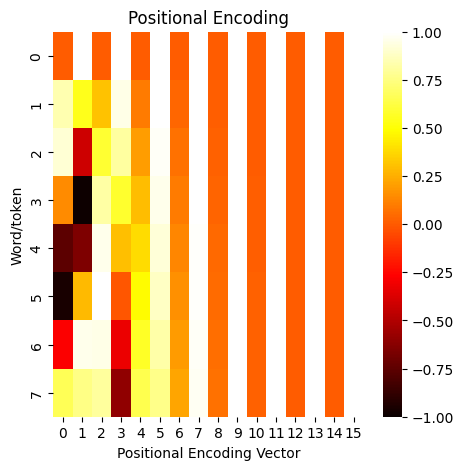

In [4]:
def get_positional_encoding(max_seq_len, d_model):
    position = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2)* -(np.log(10000.0)/d_model))
    positional_encoding = np.zeros((max_seq_len, d_model))
    positional_encoding[:,0::2] = np.sin(position * div_term)
    positional_encoding[:,1::2] = np.cos(position * div_term)
    return torch.tensor(positional_encoding, dtype = torch.float)

# Plot our positional encoding
def plot_heatmap(data, title):
    plt.figure(figsize=(5,5))
    seaborn.heatmap(data, cmap="hot", vmin=-1, vmax=1)
    plt.ylabel("Word/token")
    plt.xlabel("Positional Encoding Vector")
    plt.title(title)
    plt.show()

max_seq_len =len(sentence.split())
d_model = embedding_size
positional_encodings = get_positional_encoding(max_seq_len, d_model)
plot_heatmap(positional_encodings, 'Positional Encoding')

In [5]:
final_embedding = word_embeddings + positional_encodings
print(final_embedding)


tensor([[ 1.2610,  1.3947, -0.2458,  0.9220,  0.6508,  0.6551,  0.5701,  1.9257,
         -0.9518,  2.2330, -0.9021,  1.5686,  0.8311, -0.4876,  0.0651,  2.8359],
        [ 1.4217,  0.9941,  0.0385,  0.8394, -0.5800,  1.4276,  0.1008,  1.9963,
          0.6149,  1.6454, -1.4666, -0.6431, -1.1915,  0.7073,  0.0690,  0.4842],
        [ 0.0055,  1.1554,  1.7585,  0.9542, -1.0724, -0.0566, -1.3352,  1.5012,
          0.6239,  2.2929,  0.3475, -0.0128, -0.0607,  1.3905,  0.8124,  2.2936],
        [ 0.1825, -0.9114,  1.3403,  2.3633, -1.3455, -0.1527, -1.2822, -0.2794,
          0.3164,  0.1627,  0.1768,  0.1662,  1.2007,  0.9046,  0.4272,  1.0083],
        [-0.3851, -1.7579,  1.2570,  0.6049, -0.9294,  0.8730,  0.7867,  0.8346,
          0.4894,  0.4453,  0.9362, -0.4786, -0.5163, -0.2845,  0.2999,  0.9734],
        [-2.8483, -0.0082,  2.6490, -0.6504, -1.2004,  2.3844,  1.9099,  0.1336,
         -0.5125,  1.8313, -1.0202,  1.0001,  0.3269,  1.5039, -1.0421,  1.6314],
        [-0.2203,  0.3

In [6]:
## Building Decoder from Scratch!

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout):
        super(DecoderBlock,self).__init__()
        # The first part of the __init__ defines the hyperparameters for the DecoderBlock
        # d_model = dim of input vector
        # num_head = num of heads in multihead attention mechanism

        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(d_model, ff_hidden_dim)
        self.linear2 = nn.Linear(ff_hidden_dim, d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        attn_output, _ = self.self_attention(x,x,x, attn_mask = tgt_mask)
        x=x+self.dropout1(attn_output)
        x=self.norm1(x)
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + self.dropout2(ff_output)
        x =x + self.norm2(x)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0,1)
        self.register_buffer("pe", pe)


    def forward(self, x):
        x = x+ self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_hidden_dim, dropout):
        super(TransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_block = DecoderBlock(d_model, num_heads, ff_hidden_dim, dropout)
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        tgt_mask = generate_square_subsequent_mask(x.size(0))
        x = self.transformer_block(x, tgt_mask)
        output = self.linear(x)
        output = self.softmax(output)
        return output


tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1355: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


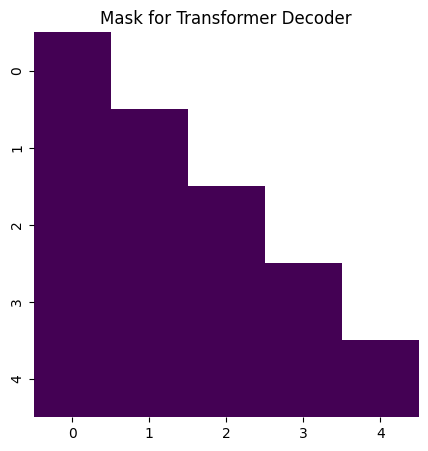

In [7]:


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz))== 1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask==1, float(0.0))
    return mask
mask = generate_square_subsequent_mask(sz=5)
print(mask)

plt.figure(figsize=(5,5))
seaborn.heatmap(mask, cmap="viridis", cbar=False, square=True)
plt.title("Mask for Transformer Decoder")
plt.show()


In [8]:
# Let's build our decoder
vocab_size = 1000
d_model = 512
num_heads = 1
ff_hidden_dim = 2*d_model
dropout = 0.1
num_layers = 10
context_length = 50
batch_size = 1

model = TransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout)
input_tensor = torch.randint(0, vocab_size, (context_length, batch_size))
output = model(input_tensor)
print(output.shape)
predicted_indices = output.argmax(dim=-1)
print(predicted_indices.shape)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

torch.Size([50, 1, 1000])
torch.Size([50, 1])
The model has 3,127,784 trainable parameters


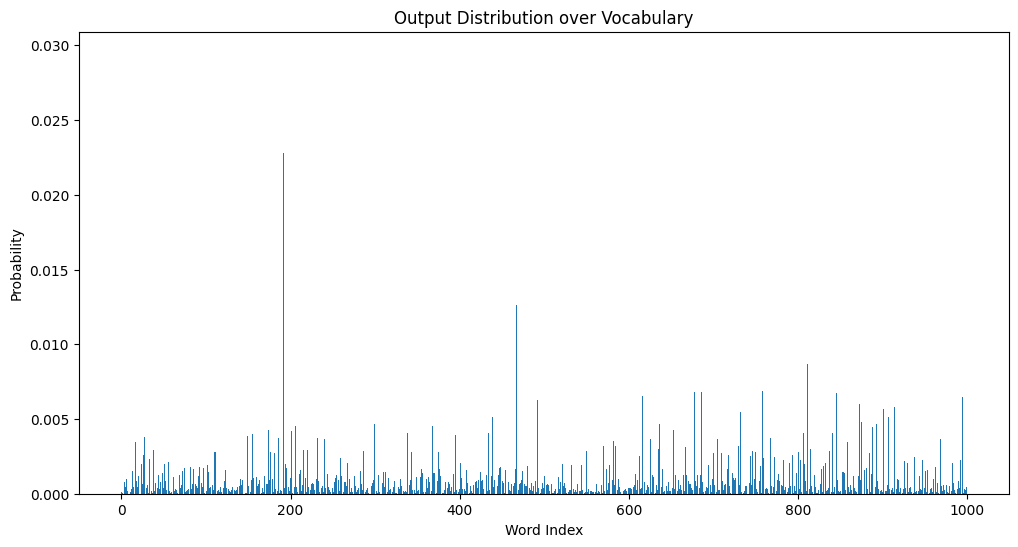

In [9]:
# Looking at oupputs
# convert log probabilities into probabilities
distribution = torch.exp(output[0, 0, :])
distribution = distribution.detach().numpy()

plt.figure(figsize=(12,6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

In [10]:
class MultiLayerTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers):
        super(MultiLayerTransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, ff_hidden_dim, dropout)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        for transformer_block in self.transformer_blocks:
            tgt_mask = generate_square_subsequent_mask(x.size(0))
            x = transformer_block(x,tgt_mask)
        output = self.linear(x)
        output = self.softmax(output)
        return output


The model has 544,552,720 trainable parameters


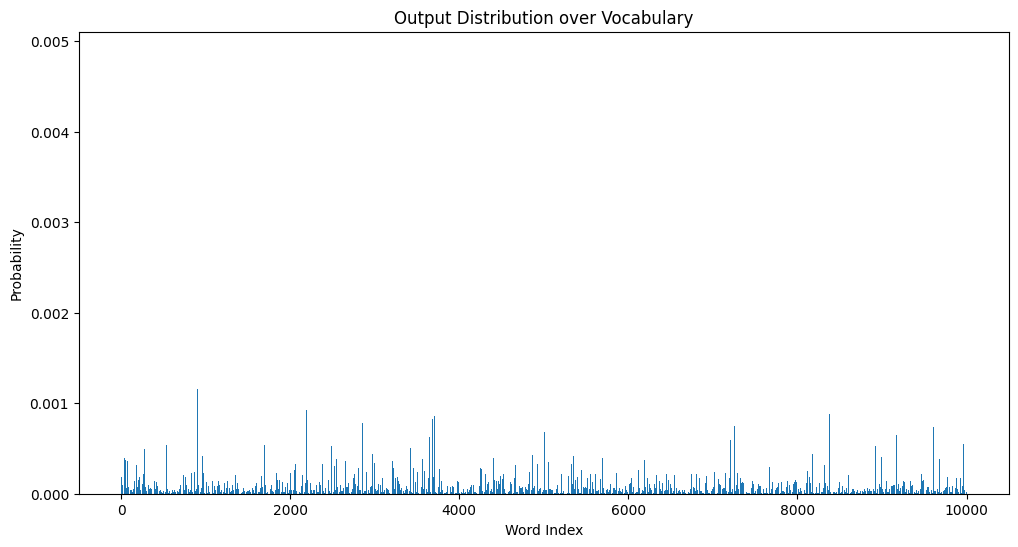

In [11]:
# Define the hyperparameters
vocab_size     = 10000
d_model        = 2048
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 10
context_length = 100
batch_size     = 1

input_tensor = torch.randint(0, vocab_size, (context_length, batch_size))

# Initialize the model with `num_layer` layers
model = MultiLayerTransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers)

# Print the number of trainable parameters
print(f"The model has {count_parameters(model):,} trainable parameters")

# Let's use the same input_tensor from the previous example
output = model(input_tensor)

# Convert the log probabilities to probabilities for the first sequence in the batch and the first position in the sequence
distribution = torch.exp(output[0, 0, :])

# Convert the output tensor to numpy array
distribution = distribution.detach().numpy()

# Now plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel("Word Index")
plt.ylabel("Probability")
plt.title("Output Distribution over Vocabulary")
plt.show()

In [12]:
# Define the hyperparameters
d_model        = 100
num_heads      = 1
ff_hidden_dim  = 4*d_model
dropout        = 0.1
num_layers     = 4
context_length = 5
batch_size     = 1
# Define the vocabulary
vocab = ["of", "in", "to", "for", "with", "on", "at", "from", "by", "about", "as", "into", "like", "through", "after", "over", "between", "out", "against", "during", "without", "before", "under", "around", "among"]
vocab_size = len(vocab)

# Create a dictionary that maps words to indices
word2id = {word: id for id, word in enumerate(vocab)}

# Create a dictionary that maps indices to words
id2word = {id: word for id, word in enumerate(vocab)}

# Initialize the model
model = MultiLayerTransformerDecoder(vocab_size, d_model, num_heads, ff_hidden_dim, dropout, num_layers)

# Create a tensor representing a single sequence of variable length
# Here we randomly select words from our vocabulary
sequence = ["of", "in", "to", "for", "with", "on", "at"][:context_length]
input_tensor = torch.tensor([[word2id[word] for word in sequence]])

# Generate a sequence of words
generated_words = []
for i in range(10):  # Generate 10 words
    output = model(input_tensor)
    predicted_index = output.argmax(dim=-1)[0, -1]  # Take the last word in the sequence
    predicted_word = id2word[predicted_index.item()]
    print(predicted_word, end=" ")
    generated_words.append(predicted_word)
    input_tensor = torch.cat([input_tensor, predicted_index.unsqueeze(0).unsqueeze(0)], dim=-1)  # Append the predicted word to the input
    time.sleep(0.75)  # Pause for 1 second


around around at for around without for from from at 

# Using trained model and bigger vocab

In [13]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer_small = GPT2Tokenizer.from_pretrained('gpt2')
model_small = GPT2LMHeadModel.from_pretrained('gpt2')


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [14]:
prompt = "This is a MOOC about large language models, I have only just started, but already"

In [15]:
inputs_small = tokenizer_small.encode(prompt, return_tensors='pt')
attention_mask_small = torch.ones(inputs_small.shape, dtype= torch.long)
pad_token_id_small = tokenizer_small.eos_token_id
print(prompt, end=" ", flush=True)

for _ in range(50):
    outputs_small = model_small.generate(inputs_small, max_length = inputs_small.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_small, attention_mask=attention_mask_small)
    generated_word = tokenizer_small.decode(outputs_small[0][-1])
    print(generated_word, end=' ', flush=True)
    inputs_small = torch.cat([inputs_small, outputs_small[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)
    attention_mask_small = torch.cat([attention_mask_small, torch.ones((1,1), dtype=torch.long)], dim=-1)
    time.sleep(0.7)

print("\nGPT-2 Small completed!")


This is a MOOC about large language models, I have only just started, but already  have  a  lot  of  stuff  written .  I  intend  to  release  it  in  three  parts . 
 
 Introduction 
 
 Introduction  to  MO OC s  is  not  an  " ex plan ation ."  It  is  just  a  framework  for  working  together  on  the  content  of  small  websites  and  forums 
GPT-2 Small completed!


In [ ]:
tokenizer_large = GPT2Tokenizer.from_pretrained("gpt2-XL")
model_large = GPT2LMHeadModel.from_pretrained("gpt2-XL")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Generate text with GPT-2 XL
inputs_large = tokenizer_large.encode(prompt, return_tensors="pt")

# Add in the attention mask and pad token id
attention_mask_large = torch.ones(inputs_large.shape, dtype=torch.long)  # Creating a mask of ones with the same shape as inputs
pad_token_id_large = tokenizer_large.eos_token_id  # Get the eos_token_id from the tokenizer

print(prompt, end=" ", flush=True)
for _ in range(25):  # Generate 25 words
    outputs_large = model_large.generate(inputs_large, max_length=inputs_large.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id_large,
                                         attention_mask=attention_mask_large)
    generated_word = tokenizer_large.decode(outputs_large[0][-1])
    print(generated_word, end=" ", flush=True)
    inputs_large = torch.cat([inputs_large, outputs_large[0][-1].unsqueeze(0).unsqueeze(0)], dim=-1)
    attention_mask_large = torch.cat([attention_mask_large, torch.ones((1, 1), dtype=torch.long)], dim=-1)
    time.sleep(0.7)
print("\nGPT-2 XL completed.")

This is a MOOC about large language models, I have only just started, but already  it  seems  to  be  very  successful .  https :// www . cour ser a . org / course / sc am /  https :// www 
GPT-2 XL completed.
